# Learning Quantum State Representations

Goal: Neural networks reconstruct a quantum state from measurements using a supervised an an unsupervised approach.

This notebook showcases dataset generation, model training and evaluation. Hyperparameter tuning and the examination of the latent representation learned by the autoencoder are not shown.

In [1]:
# General Imports
import numpy as np
import csv
import time
import os
from datetime import datetime as dtime
import re
from scipy.stats import unitary_group
from tqdm import trange, tqdm

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 14,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# IPython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Global definitions

In [2]:
# Number of qubits in considered system
# Dimension of Hilbert space is 2 ** NQ
# Total independent parameters in state density matrix is 4**NQ -1

NQ = 1
state_gen_method = 'random_uniform_vector'

assert state_gen_method in ['unitary_column', 'random_uniform_vector']

In [3]:
# State Visualization

def plot_dm(astate, title='', save_path=False, fixed_scale=False):

    # Make square matrix
    if len(astate.shape) == 1:
        dim = int(np.sqrt(len(astate)))
        astate = astate.reshape(dim, dim)
    else:
        dim = len(astate)

    # Init arrays
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()

    fig = plt.figure(dpi=80)

    # Optionally setting scale
    if fixed_scale:
        vmin, vmax = fixed_scale
    else:
        vmin=min(dz)
        vmax=max(dz)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=vmin, vmax=vmax, cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    if title != '':
        fig.suptitle(title)

    if save_path: plt.savefig(save_path, dpi=120)

    plt.show()

# State Generator

## Pure states

In [4]:
if state_gen_method == 'unitary_column':
    def create_pure_rho(nqubits):
        # Generate a pure quantum state from sampling a random unitary matrix and
        # taking the first column vector 
        dim = 2**nqubits
        psi = unitary_group.rvs(dim)[0]
        rho = np.outer(psi, psi.T.conjugate())
        
        # Check Positive semi-definiteness condition
        if not np.all(np.linalg.eigvals(rho) >= -1e-10):
            return create_pure_rho(nqubits)

        # Normalize density matrix
        rho /= np.trace(rho)

        return rho

if state_gen_method == 'random_uniform_vector':
    def create_pure_rho(nqubits):
        # Generate a pure quantum state from random numbers sampled from uniform distribution [-1,1]
        dim = 2**nqubits
        psi =   np.random.uniform(low=-1, high=1, size=dim) +\
                1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())

        # Check Positive semi-definiteness condition
        if not np.all(np.linalg.eigvals(rho) >= -1e-10):
            return create_pure_rho(nqubits)

        # Normalize density matrix
        rho /= np.trace(rho)
        
        return rho

In [5]:
# Test Purity condition Tr(rho**2) == 1
print('Traces of 100 test 1qubit states squared = 1?')
traces = np.array([create_pure_rho(nqubits=NQ) for _ in range(100)])
traces = np.array([np.trace(np.real(rho.dot(rho))) for rho in traces])
np.all( (traces-1) < 1e-10 )

Traces of 100 test 1qubit states squared = 1?


True

## Mixed States

In [6]:
def partial_trace(rho):
    # Generate a mixed state in Hilbert space H by tracing over one subsystem of a state in H \tensor H
    dim = 2**NQ
    reduced = np.zeros((dim,dim), dtype=np.complex128)
    for bvec in np.eye(dim):
        bra = np.kron(np.eye(dim), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

In [7]:
# Wrapper function for generating pure and mixed states
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=NQ)
    else:
        return partial_trace(create_pure_rho(nqubits=NQ*2))

Tr(rho) =  (1+0j)
Tr(rho**2) =  (0.65+0j)


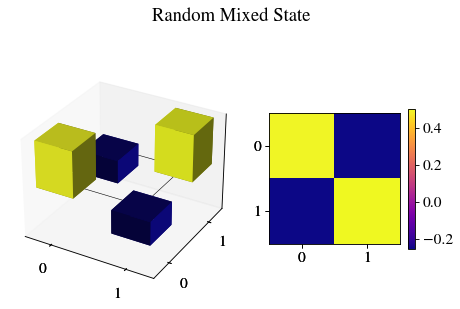

In [8]:
# Test generation of mixed state
astate = random_rho(pure=False)
print('Tr(rho) = ', np.round(np.trace(astate),2))
print('Tr(rho**2) = ',np.round(np.trace(astate.dot(astate)),2))
plot_dm(np.real(astate), title='Random Mixed State')

### Bloch vector method

## Trace Distributions

### Mixed states from partial trace

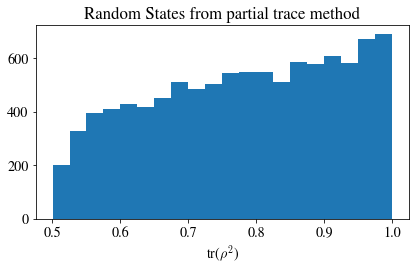

In [9]:
n = 10000
traces = np.array([random_rho(pure=False) for _ in range(n)])
traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
a=plt.hist(np.real(traces), bins=20)
a=plt.xlabel('tr($\\rho^2$)')
a=plt.title('Random States from partial trace method')

## Retrieve independent values from density matrix

In [10]:
# Compressing density matrix to array with independent values
# Processing complex units is not yet implemented to pytorch, treating complex values as two ndependent real values

def rho2torch(rho):
    # Convert an NQ * NQ density matrix with complex entries to an 1D array holding all 4 * NQ - 1 degrees of freedom
    dim = 2**NQ
    rho = rho.reshape(dim, dim)

    # First NQ entries of array are real diagonal values from density matrix
    diags = np.array([np.real(rho[i,i]) for i in range(dim-1)])

    # Stack complex values of upper right, triangular, off-diagonal matrix as two independent real numbers each
    ur = np.array([])
    for i in range(dim-1):
        ur = np.hstack((ur, rho[i][i+1:dim]))
    ur = np.hstack((np.real(ur), np.imag(ur)))
    return np.hstack((diags, ur))

def torch2rho(tensor):
    # Convert an 1D Array holding all 4 * NQ - 1 degrees of freedom to NQ * NQ density matrix with complex entries
    # Backtransformation regarding rho2torch

    # Build diagonal matrix from first NQ entries of array
    dim = 2**NQ
    diag_coeff = np.array(tensor[:dim-1])
    norm_coeff = 1 - np.sum(diag_coeff)
    diags = np.hstack((diag_coeff, norm_coeff))
    diags = np.diag(diags)

    # Build upper right, triangular, off-diagonal matrix
    num_ur_entries = np.sum(np.arange(dim))
    ur_real = tensor[dim-1:dim-1+num_ur_entries]
    ur_imag = tensor[dim-1+num_ur_entries:]

    ur = np.zeros((dim,dim), dtype='complex64')
    for i in range(num_ur_entries):
        for j in range(i+1, dim):
            ur[i,j] = ur_real[0] + 1.j* ur_imag[0]
            ur_real = np.delete(ur_real, 0)
            ur_imag = np.delete(ur_imag, 0)
    return diags + ur + ur.T.conjugate()

In [11]:
# Test if forward and backward transformation result in identity
astate = np.round(random_rho(pure=False), NQ)
bstate = torch2rho(rho2torch(astate))

print("Do rho and rho2torch2rho coincide?")
np.all((astate - bstate) < 1e10)

Do rho and rho2torch2rho coincide?


True

# Measurement

## Create random set of Projectors
Using random pure states as projectors.
One random Projector defines a minimal Projector Valued Measure.

In [12]:
def create_random_pro(pure, n=100):
    # Creating set of projectors from random density matrices
    return np.array([random_rho(pure=pure) for _ in range(n)])

def perform_measurements(rho, pro):
    # Perform Measurement by calculating trace
    return np.real( np.trace(pro.dot(rho), axis1=1, axis2=2) )

mean = 0.501381879360519
std = 0.20295010837326743


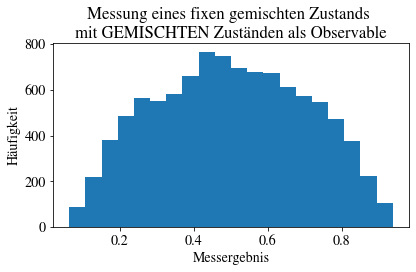

In [13]:
# Examining distribution of measurement outcomes of random projections to MIXED states for a fixed mixed state being measured

base_state = random_rho(pure=False)
projectors = create_random_pro(pure=False, n=10000)

meas = perform_measurements(base_state, projectors)
print('mean =', meas.mean())
print('std =', meas.std())

a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit GEMISCHTEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')
#a=plt.xlim(0,1)

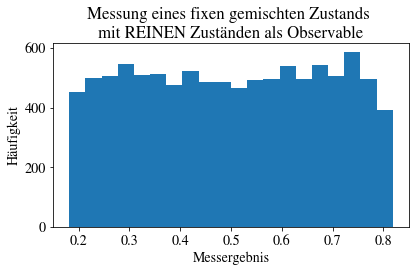

In [14]:
# Examining distribution of measurement outcomes of random projections to PURE states for a fixed mixed state being measured

base_state = random_rho(pure=False)
observables = create_random_pro(pure=True, n=10000)

meas = perform_measurements(base_state, observables)


a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit REINEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')

## Create Dataset

Generate ```n_states``` random mixed states and perform a set of ```n_pro``` projections on each state.
Multiple sets of projectors are held in ```pro_arr```.

In [15]:
# Set parameters for new dataset
n_states = int(5e4)
exp_title = 'tomoAE2Q'
pro_arr = [30]

In [ ]:
# Generate folders
experiment_name = exp_title + f'_{NQ}qubit_'+ state_gen_method
if not os.path.isdir('./data/' + experiment_name):
    os.mkdir('./data/' + experiment_name)

  
# Iterate through multiple set of fixed projectors
for n_pro in tqdm(pro_arr):
  for _ in range(10):
    n_observables = n_pro
    observables = create_random_pro(pure=True, n=n_observables)
    states = np.array([random_rho(pure=False) for _ in range(n_states)])
    states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters

    # Generate folder for new dataset
    timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
    PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{n_observables}/'
    DATAPATH = PARENTPATH+f"run_{timestamp}/"
    if not os.path.isdir(PARENTPATH):
      os.mkdir(PARENTPATH)
    os.mkdir(DATAPATH)

    # Write out states
    with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
      writer = csv.writer(f)
      for state in tqdm(states_freeparams):
        a=writer.writerow(state)
        
    # Write out observables
    with open(DATAPATH + 'observables.csv', 'w') as f:
      writer = csv.writer(f)
      for obs in tqdm(observables):
        a=writer.writerow(obs.reshape(4**(NQ)))

    # Write out measurements 
    with open(DATAPATH + 'measurements.csv', 'w') as f:
      writer = csv.writer(f)
      for state in tqdm(states):
        a=writer.writerow(perform_measurements(state, observables))

    # Wait a sec so the next dataset gets a new name
    time.sleep(1)


# Supervised State Representations (FFN)

### Load dataset

In [17]:
class QuantumMeasurementDataset(Dataset):
    def __init__(self, root_dir):
        self.measurements_frame = pd.read_csv(root_dir + 'measurements.csv', header=None)
        self.states_frame = pd.read_csv(root_dir + 'states_freeparams.csv', header=None)

    def __len__(self):
        return len(self.states_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        measurement = self.measurements_frame.iloc[idx]
        measurement = np.array(measurement).astype('float')
        measurement = torch.Tensor(measurement)

        state = self.states_frame.iloc[idx]
        state = np.array(state).astype('float')
        state = torch.Tensor(state)

        return measurement, state


In [18]:
def load_dataset(datadir, nstat, BATCH_SIZE = 64, splits = np.array([0.8, 0.1, 0.1])):
    # Train_valid_treasure split
    assert np.sum(splits) == 1

    tomography_dataset = QuantumMeasurementDataset(root_dir=datadir)
    tomography_train_dataset, tomography_valid_dataset, tomography_treasure_dataset = torch.utils.data.random_split(\
        tomography_dataset, (nstat*splits).astype(int), generator=torch.Generator().manual_seed(42))

    # Create data loaders from the datasets for the current task
    # Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
    tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_treasure_dataloader = DataLoader(tomography_treasure_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    return tomography_train_dataloader, tomography_valid_dataloader, tomography_treasure_dataloader 

## Feed Forward Network

Training an FFN to predict the quantum state being measured from results of random Projective Valued Masurements.

Projections --> quantum state

In [19]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
# Initializing FFN with fixed hidden layer sizes

class FeedForwardNet(nn.Module):
  def __init__(self, n_obs):
    super().__init__()

    self.dof = 4**NQ - 1
    self.layer_sizes = [n_obs, 64, 32]
    
    self.layers = nn.Sequential(
    nn.Linear(self.layer_sizes[0], self.layer_sizes[1]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[1], self.layer_sizes[2]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[2], self.dof),
    )

  def forward(self, x):
    return self.layers(x)

## Training

In [21]:
# Evaluate the Mean Squared Error for a net on dataset
def evaluate_mse_ffn(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements, target = batch[0].to(device), batch[1].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, target).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [22]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for _ in trange(train_epochs):
        net.train()
        for _, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ffn(net, valid_dataloader, criterion, device))
    return train_losses, valid_losses

In [23]:
def plot_train_stats(train_losses, valid_losses, it_per_epoch, path):
    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/train_losses.png', dpi=150)
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/valid_losses.png', dpi=150)
    plt.show()

In [24]:
def ffn_wrapper(data_dir, model_title, nstat, nobs, nepochs, learning_rate, batch_size, splits = np.array([0.8, 0.1, 0.1])):
    # Wrapper function for initializing net, criterion, optimizer, for netwirk training and automatic saving

    # Extract the run name from string 'data_dir'
    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)

    #Load dataset
    tomography_train_dataloader, tomography_valid_dataloader, _ = load_dataset(data_dir, nstat, batch_size, splits)

    # Create the network on the CPU/GPU
    net = FeedForwardNet(n_obs=nobs).to(device)
    print(net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Perform Training
    train_losses, valid_losses = train(net, nepochs, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

    # Save Model
    path = f'./models/FFN_states{int(nstat)}_obs{nobs}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(tomography_train_dataloader), path=path)


In [25]:
def train_multiple_runs(dataexp_path, model_title, nstat, obs_arr, bs, lr, nepochs):
    # Function for training models on multiple datasets and automated saving

    # Retrieve all combinations of dataset hyperparameters available
    hyperparameter_dir = [f'states{int(nstat)}_obs{n_obs}' for n_obs in obs_arr]
    for nobs, hdir in zip(obs_arr, hyperparameter_dir):
        hpath = dataexp_path + '/' + hdir

        # Retrieve all datasets for given dataset hyperparameters (nstates, nobs)
        run_directories = [f for f in os.listdir(hpath) if os.path.isdir(os.path.join(hpath, f))]
        for rdir in run_directories:
            run_path = hpath + '/' + rdir + '/'
            ffn_wrapper(data_dir = run_path,
                        model_title=model_title,
                        nstat=nstat,
                        nobs=nobs,
                        nepochs=nepochs,
                        learning_rate=lr, 
                        batch_size=bs, 
                        splits = np.array([0.8, 0.1, 0.1]))

## Evaluation

### MSE on unseen dataset


In [26]:
nstat = int(1e4)
nobs = 3
model_path = 'models/FFN_states10000_obs3_epochs15_lr0.001_ConstLatentDimension_run_20220604_092923'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [27]:
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))
_, _, tomography_treasure_dataloader = load_dataset(datadir=data_path+'/', nstat=nstat)

print('Mean Square Error on unseen data')
untrained_net = FeedForwardNet(n_obs=nobs).to(device)
print('Untrained Net: ', evaluate_mse_ffn(
    untrained_net, tomography_treasure_dataloader,nn.MSELoss(),device))
print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

<All keys matched successfully>

Mean Square Error on unseen data
Untrained Net:  0.1679292917251587
Trained Net:  9.949736947116132e-06


### Inference

In [28]:
# Import Observables
dim = 2**NQ
data_obs = np.zeros((0,dim,dim))
with open(data_path+'/observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

3it [00:00, 4452.55it/s]


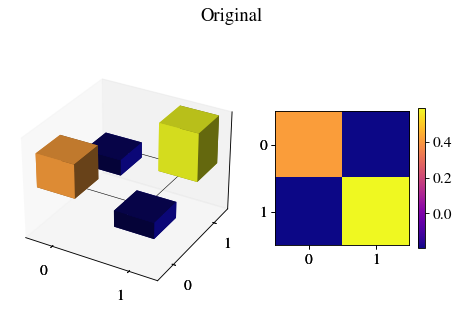

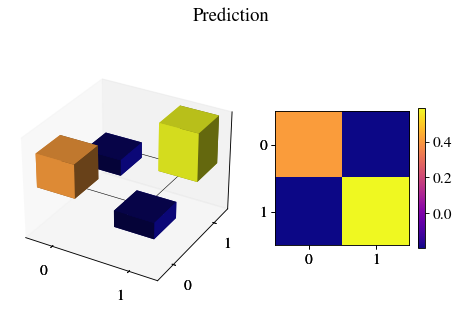

In [29]:
# Initialize a random state and perform measurements
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))

# Evaluate Network on measurement probabilities and plot prediction
freeparam_pred = load_net.forward(m_infer.to(device)).detach().cpu().numpy()
rho_pred = torch2rho(freeparam_pred)
plot_dm(np.real(rho_infer), title='Original')
plot_dm(np.real(rho_pred), title='Prediction')

# Unsupervised State Representations (AE)

## Autoencoder

In [30]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_dim, measurement_dim):
    super().__init__()

    self.layer1_size = 64
    self.layer2_size = 32

    self.encoder = nn.Sequential(
    nn.Linear(measurement_dim, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, latent_dim),
    )

    self.decoder = nn.Sequential(
    nn.Linear(latent_dim, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, measurement_dim),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output
  
  def encode(self, x):
    return self.encoder(x)

## Training

In [31]:
def evaluate_mse_ae(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements = batch[0].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, measurements).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [32]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ae(net, valid_dataloader, criterion, device))

    return train_losses, valid_losses

In [33]:
# Wrapper Function for network training  and evaluation on unseen data
def ae_train_eval(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs):

    # Retrieve name of dataset from data_dir
    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)

    # Load data
    train_dataloader, valid_dataloader, treasure_dataloader = load_dataset(data_dir+'/', nstat)

    # Create the network on the CPU/GPU
    ae_net = AutoencoderNet(measurement_dim=nobs, latent_dim=latent_size).to(device)

    # Initialize loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae_net.parameters(), lr=learning_rate)

    # Network training
    train_losses, valid_losses = ae_train(  ae_net, 
                                            nepochs, 
                                            train_dataloader, 
                                            valid_dataloader, 
                                            optimizer, 
                                            criterion)

    # Log the loss on the unseen set                  
    treasure_loss = evaluate_mse_ae(ae_net, treasure_dataloader, criterion, device)

    # Save Model
    path = f'./models/AE_states{int(nstat)}_obs{nobs}_latentdim{latent_size}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(ae_net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(train_dataloader), path=path)

    return treasure_loss


In [34]:
# Function for training autoencoders with varying dimensions of latent layer
# for multiple datasets with fixed hyperparameters
def ae_train_multiple_runs(data_path, model_title, latent_dims, nstat, nobs, lr, nepochs):
    performances = np.array([])

    # Retrieve directories of datasets
    run_directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        run_perf = np.array([])

        # Train autoencoders for multiple latent layer dimensions
        for ldim in latent_dims:
            perf = ae_train_eval(data_dir=run_path,
                            model_title=model_title,
                            nstat=nstat,
                            nobs=nobs,
                            latent_size=ldim, 
                            learning_rate=lr, 
                            nepochs=nepochs)
            print(perf)
            run_perf = np.append(run_perf, perf)
        performances = np.append(performances, run_perf)
    return performances

In [42]:
# Wrapper Function for evaluating an autoencoder model on a dataset
def ae_treasure_evaluation(n_states, nobservables, latent_size, data_path, model_path=None):
    # Load unseen dataset
    _, _, treasure_dataloader = load_dataset(data_path+'/', n_states)
    
    # Initialize new network
    load_net = AutoencoderNet(measurement_dim=nobservables, latent_dim=latent_size).to(device)
    
    # Load trained parameters of specified
    if model_path: load_net.load_state_dict(torch.load(model_path+'/model.model'))

    return evaluate_mse_ae(load_net, treasure_dataloader, nn.MSELoss(), device)

## Evaluation

### MSE on unseen dataset 

In [43]:
n_states = 1e4
n_proj = 100
latent_dim = 3
ae_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092835'
ae_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092835'

In [44]:
print('Mean Square Error on unseen data')
print('Untrained Net: ', ae_treasure_evaluation(n_states, n_proj, latent_dim, ae_data_path))
print('Trained Net: ', ae_treasure_evaluation(n_states, n_proj, latent_dim, ae_data_path, ae_model_path))

Mean Square Error on unseen data
Untrained Net:  0.3051785926024119
Trained Net:  1.1141267471733347e-05
